In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns
import plotly.graph_objects as go
import plotly.graph_objects as go
from sktime.forecasting.model_selection import temporal_train_test_split
from tabulate import tabulate

%matplotlib inline

import warnings
import datetime

warnings.filterwarnings("ignore")

In [2]:
streaming=pd.read_csv('cpu4.csv')
for i in range(len(streaming)):
    streaming['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(streaming['timestamp'].iloc[i]) #We are given the timestamp as a unix code
cols=[i for i in streaming.columns if i not in ['timestamp']]
for col in cols:
    streaming[col]=pd.to_numeric(streaming[col])
streaming['timestamp'] = pd.to_datetime(streaming['timestamp'])

streaming.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17568 entries, 0 to 17567
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  17568 non-null  datetime64[ns]
 1   value      17568 non-null  float64       
 2   label      17568 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 411.9 KB


In [3]:
streaming

,timestamp,value,label
0,2016-07-24 20:00:00,0.847300,0
1,2016-07-24 20:05:00,-0.036137,0
2,2016-07-24 20:10:00,0.074292,0
3,2016-07-24 20:15:00,0.074292,0
4,2016-07-24 20:20:00,-0.036137,0
...,...,...,...
17563,2016-09-23 19:35:00,0.074292,0
17564,2016-09-23 19:40:00,0.295152,0
17565,2016-09-23 19:45:00,0.074292,0
17566,2016-09-23 19:50:00,-0.146567,0


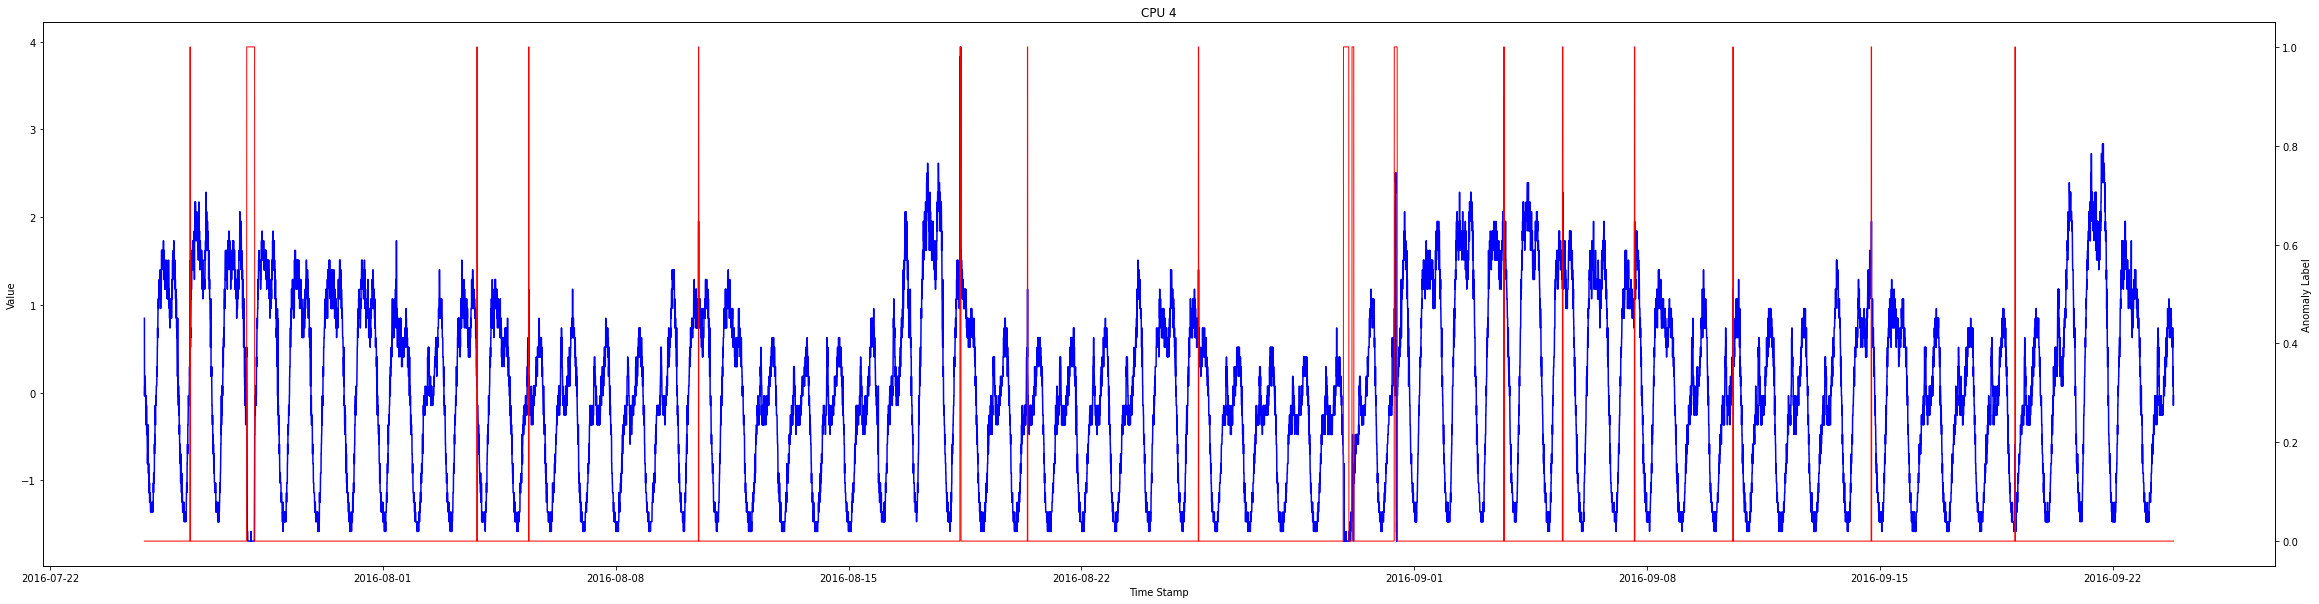

In [4]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
ax2d.plot(streaming['timestamp'], streaming['value'], color='blue')
ax2a.plot(streaming['timestamp'], streaming['label'], color='red', linewidth='1')
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('Value')
ax2a.set_ylabel('Anomaly Label')
ax2d.title.set_text('CPU 4')

# Streaming Dataset

In [5]:
streaming_dataset=streaming[['timestamp', 'value']]
#dataset

# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(streaming_dataset['timestamp'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

# datetime_index
period_index = pd.PeriodIndex(datetime_index, freq='S')

# period_index
streaming_dataset = streaming_dataset.set_index(period_index)

# we don't need the column anymore
streaming_dataset.drop('timestamp',axis=1,inplace=True)

streaming_dataset.head()
# print(len(dataset))

,value
2016-07-24 20:00:00,0.847300
2016-07-24 20:05:00,-0.036137
2016-07-24 20:10:00,0.074292
2016-07-24 20:15:00,0.074292
2016-07-24 20:20:00,-0.036137


In [6]:
contamination=1.388
contamination=contamination/100

# importing the isloation forest
from sklearn.neighbors import LocalOutlierFactor

# copying dataset
isf_dataset = streaming_dataset.copy()

# initializing Isolation Forest
clf = LocalOutlierFactor(n_neighbors=10, contamination=contamination)

# training
clf.fit(isf_dataset)

# finding anomalies
isf_dataset['Anomaly'] = clf.fit_predict(isf_dataset) 

# saving anomalies to a separate dataset for visualization purposes
# anomalies_single = isf_dataset.query('Anomaly == -1')
anomalies=isf_dataset

In [7]:
total_contamination=len(anomalies)

In [8]:
output=anomalies

In [9]:
anomalies

,value,Anomaly
2016-07-24 20:00:00,0.847300,1
2016-07-24 20:05:00,-0.036137,1
2016-07-24 20:10:00,0.074292,1
2016-07-24 20:15:00,0.074292,1
2016-07-24 20:20:00,-0.036137,1
...,...,...
2016-09-23 19:35:00,0.074292,1
2016-09-23 19:40:00,0.295152,1
2016-09-23 19:45:00,0.074292,1
2016-09-23 19:50:00,-0.146567,1


In [10]:
anomalies["Anomaly"]=anomalies["Anomaly"].replace(1, 0) #No Anomalies
anomalies["Anomaly"]=anomalies["Anomaly"].replace(-1, 1) #Anomalies
anomalies

,value,Anomaly
2016-07-24 20:00:00,0.847300,0
2016-07-24 20:05:00,-0.036137,0
2016-07-24 20:10:00,0.074292,0
2016-07-24 20:15:00,0.074292,0
2016-07-24 20:20:00,-0.036137,0
...,...,...
2016-09-23 19:35:00,0.074292,0
2016-09-23 19:40:00,0.295152,0
2016-09-23 19:45:00,0.074292,0
2016-09-23 19:50:00,-0.146567,0


In [11]:
moving_average=anomalies['Anomaly'].rolling(50).mean()
moving_average

2016-07-24 20:00:00    NaN
2016-07-24 20:05:00    NaN
2016-07-24 20:10:00    NaN
2016-07-24 20:15:00    NaN
2016-07-24 20:20:00    NaN
                      ... 
2016-09-23 19:35:00    0.0
2016-09-23 19:40:00    0.0
2016-09-23 19:45:00    0.0
2016-09-23 19:50:00    0.0
2016-09-23 19:55:00    0.0
Freq: S, Name: Anomaly, Length: 17568, dtype: float64

In [12]:
moving_average.min()

0.0

In [13]:
moving_average.std()

0.004747314253258433

In [14]:
threshold_6sigma=6*moving_average.std()
threshold_60percentmax=0.6*moving_average.max()

In [15]:
threshold_6sigma

0.028483885519550597

In [16]:
threshold_60percentmax

0.048

In [17]:
moving_average.max()

0.08

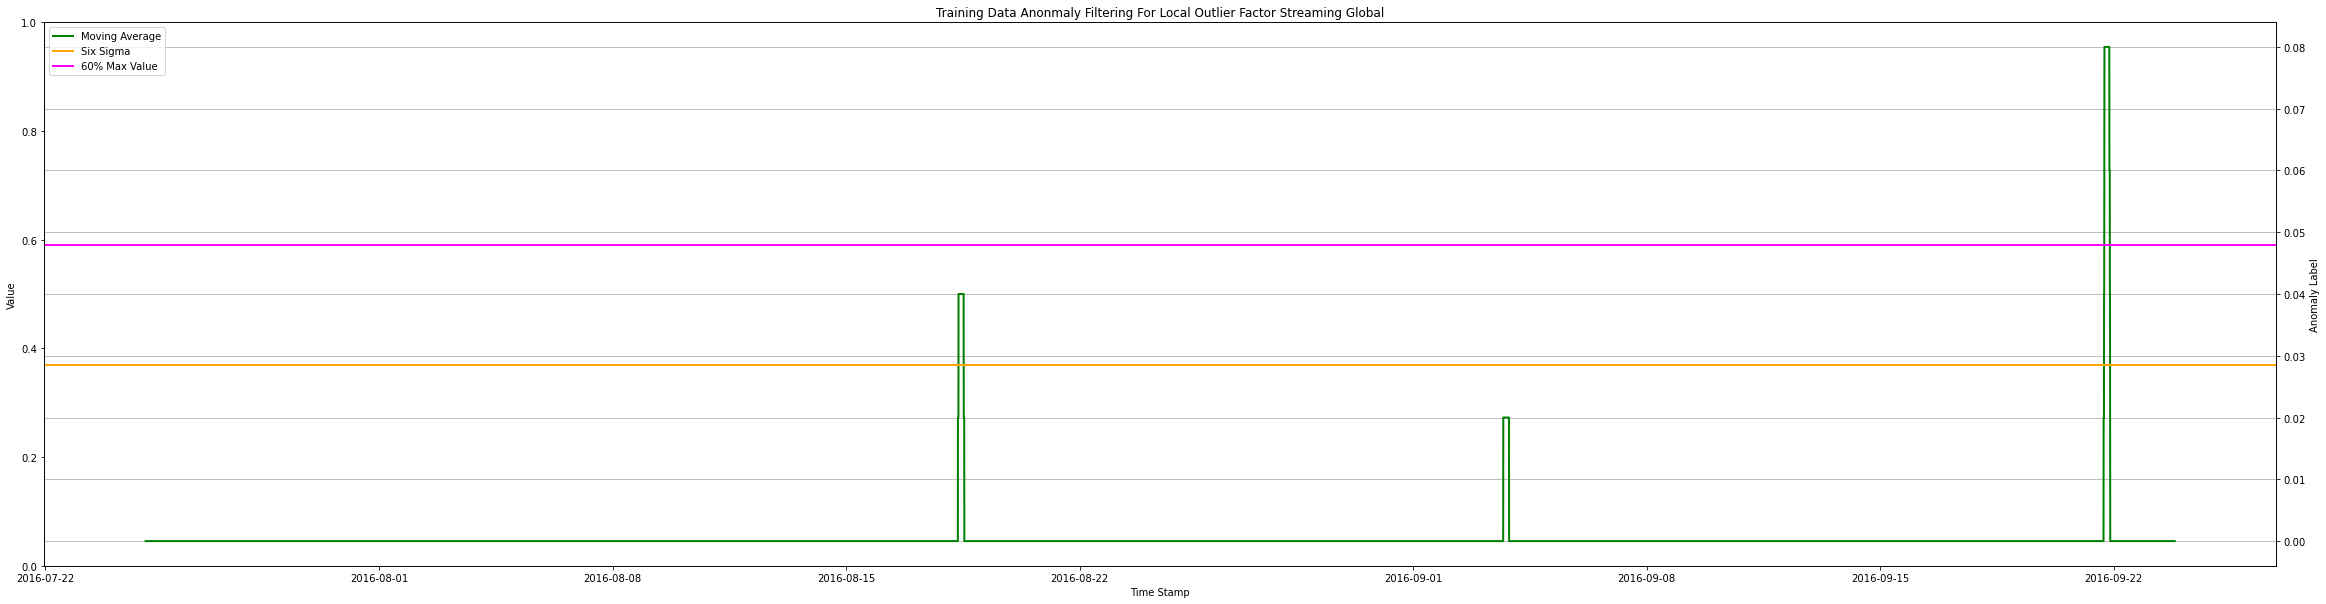

In [18]:
fig, ax2d = plt.subplots(figsize=(40,10))
ax2a = ax2d.twinx()
#ax2d.plot(huwaei['timestamp'], huwaei['kpi_value'], color='blue')
#ax2a.plot(huwaei['timestamp'], huwaei['anomaly_label'], color='red', linewidth='5')
ax2a.plot(streaming['timestamp'], moving_average, color='green', linewidth='2')
ax2a.axhline(threshold_6sigma, color='orange', linewidth='2') # Line for the six sigma
ax2a.axhline(threshold_60percentmax, color='magenta', linewidth='2') # Line for the 60% the highest value
ax2d.set_xlabel('Time Stamp')
ax2d.set_ylabel('Value')
ax2a.set_ylabel('Anomaly Label')
ax2a.legend(['Moving Average', 'Six Sigma', '60% Max Value'], loc='upper left')
plt.grid()
ax2d.title.set_text('Training Data Anonmaly Filtering For Local Outlier Factor Streaming Global')
plt.savefig('Training Data Anonmaly Filtering For Local Outlier Factor Streaming Global') 

In [19]:
moving_average=moving_average.dropna(how="all")
moving_average

2016-07-25 00:05:00    0.0
2016-07-25 00:10:00    0.0
2016-07-25 00:15:00    0.0
2016-07-25 00:20:00    0.0
2016-07-25 00:25:00    0.0
                      ... 
2016-09-23 19:35:00    0.0
2016-09-23 19:40:00    0.0
2016-09-23 19:45:00    0.0
2016-09-23 19:50:00    0.0
2016-09-23 19:55:00    0.0
Freq: S, Name: Anomaly, Length: 17519, dtype: float64

In [20]:
len(moving_average)

17519

In [21]:
threshold_60percentmax

0.048

In [22]:
n=0
a=0

new_anomalies_60percentmax=[]

for i in range(len(moving_average)):
    if moving_average[i] <= threshold_60percentmax:
        n=n+1
        t=0
        new_anomalies_60percentmax.append(t)
    elif moving_average[i] > threshold_60percentmax:
        a=a+1
        t=1
        new_anomalies_60percentmax.append(t)

        

        
print(f"Number of no anomalies: {n}")
print(f"Number of anomalies: {a}")

Number of no anomalies: 17471
Number of anomalies: 48


In [23]:
n=0
a=0

new_anomalies_6sigma=[]

for i in range(len(moving_average)):
    if moving_average[i] <= threshold_6sigma:
        n=n+1
        t=0
        new_anomalies_6sigma.append(t)
    elif moving_average[i] > threshold_6sigma:
        a=a+1
        t=1
        new_anomalies_6sigma.append(t)

        

        
print(f"Number of no anomalies: {n}")
print(f"Number of anomalies: {a}")

Number of no anomalies: 17422
Number of anomalies: 97


In [24]:
print(len(streaming['timestamp']))
print(len(new_anomalies_60percentmax))
print(len(new_anomalies_6sigma))

17568
17519
17519


In [25]:
labeled_anomalies=streaming['label'][17568-17519:17567]

In [26]:
labeled_anomalies=labeled_anomalies.reset_index(drop=True)
labeled_anomalies

0        0
1        0
2        0
3        0
4        0
        ..
17513    0
17514    0
17515    0
17516    0
17517    0
Name: label, Length: 17518, dtype: int64

In [27]:
new_anomalies_60percentmax # New Anomalies from moving average
new_anomalies_6sigma
labeled_anomalies # Labeled Anomalies

0        0
1        0
2        0
3        0
4        0
        ..
17513    0
17514    0
17515    0
17516    0
17517    0
Name: label, Length: 17518, dtype: int64

In [28]:
tp60m=0
fp60m=0
tn60m=0
fn60m=0
for i in range(len(labeled_anomalies)):
    if new_anomalies_60percentmax[i] == 1 and labeled_anomalies[i] == 1:
            tp60m=tp60m+1
    elif new_anomalies_60percentmax[i] == 1 and labeled_anomalies[i] != 1:
            fp60m=fp60m+1
    elif new_anomalies_60percentmax[i] != 1 and labeled_anomalies[i] == 1:
            fn60m=fn60m+1
    elif new_anomalies_60percentmax[i] != 1 and labeled_anomalies[i] != 1:
            tn60m=tn60m+1

In [29]:
tp6s=0
fp6s=0
tn6s=0
fn6s=0
for i in range(len(labeled_anomalies)):
    if new_anomalies_6sigma[i] == 1 and labeled_anomalies[i] == 1:
            tp6s=tp6s+1
    elif new_anomalies_6sigma[i] == 1 and labeled_anomalies[i] != 1:
            fp6s=fp6s+1
    elif new_anomalies_6sigma[i] != 1 and labeled_anomalies[i] == 1:
            fn6s=fn6s+1
    elif new_anomalies_6sigma[i] != 1 and labeled_anomalies[i] != 1:
            tn6s=tn6s+1

In [30]:
print("THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE")
print("###################################################################################")
print(f"Number of True Positives: {tp60m}")
print(f"Number of False Positives: {fp60m}")
print(f"Number of True Negatives: {tn60m}")
print(f"Number of False Negatives: {fn60m}")
print("###################################")

precision_60m=tp60m/(tp60m+fp60m)
recall_60m=tp60m/(tp60m+fn60m)
F1_Score_60m=(2*precision_60m*recall_60m)/(precision_60m+recall_60m)

print(f"Precision: {round(precision_60m,3)}")
print(f"Recall: {round(recall_60m,3)}")
print(f"F1 Score: {round(F1_Score_60m,3)}")

THIS IS FROM USING THE THRESHOLD AS 60% OF THE MAXIMUM VALUES OF THE MOVING AVERAGE
###################################################################################
Number of True Positives: 0
Number of False Positives: 48
Number of True Negatives: 17261
Number of False Negatives: 209
###################################


ZeroDivisionError: float division by zero

In [31]:
print("THIS IS FROM USING THE THRESHOLD AS 6 SIGMA VALUES OF THE MOVING AVERAGE")
print("###################################################################################")
print(f"Number of True Positives: {tp6s}")
print(f"Number of False Positives: {fp6s}")
print(f"Number of True Negatives: {tn6s}")
print(f"Number of False Negatives: {fn6s}")
print("###################################")

precision_6s=tp6s/(tp6s+fp6s)
recall_6s=tp6s/(tp6s+fn6s)
F1_Score_6s=(2*precision_6s*recall_6s)/(precision_6s+recall_6s)

print(f"Precision: {round(precision_6s,3)}")
print(f"Recall: {round(recall_6s,3)}")
print(f"F1 Score: {round(F1_Score_6s,3)}")

THIS IS FROM USING THE THRESHOLD AS 6 SIGMA VALUES OF THE MOVING AVERAGE
###################################################################################
Number of True Positives: 3
Number of False Positives: 94
Number of True Negatives: 17215
Number of False Negatives: 206
###################################
Precision: 0.031
Recall: 0.014
F1 Score: 0.02
